<a href="https://www.kaggle.com/code/arjitgupta2003/notebook8394410218?scriptVersionId=297727955" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Project: Coordinate Regression from Images

## Dataset Rationale
For this problem, I generated a synthetic dataset of 50x50 grayscale images.
* **Uniform Distribution:** The white pixel (value 255) is placed at random (x, y) coordinates drawn from a uniform distribution. This ensures the model learns to generalize across the entire spatial grid and does not bias towards specific regions (like the center).
* **Normalization:** Pixel values are normalized to [0, 1] and coordinates are normalized to [0, 1] during training to ensure stable gradient descent and faster convergence.

## Model Approach
I used a Convolutional Neural Network (CNN) because it is translation-invariant and excellent at detecting local features (like a single white pixel) regardless of its position in the image.
* **Output Layer:** The model uses a dense layer with 2 units (for x and y) and a `sigmoid` activation because the targets are normalized between 0 and 1.

## Dependencies
* TensorFlow / Keras
* NumPy
* Matplotlib
* Seaborn

Generating dataset...
Train shape: (10000, 50, 50), Labels: (10000, 2)
Val shape: (2000, 50, 50), Labels: (2000, 2)
Test shape: (1000, 50, 50), Labels: (1000, 2)
Dataset saved to dataset.npz
Generating sample visualization...
Sample visualization saved to sample_images.png


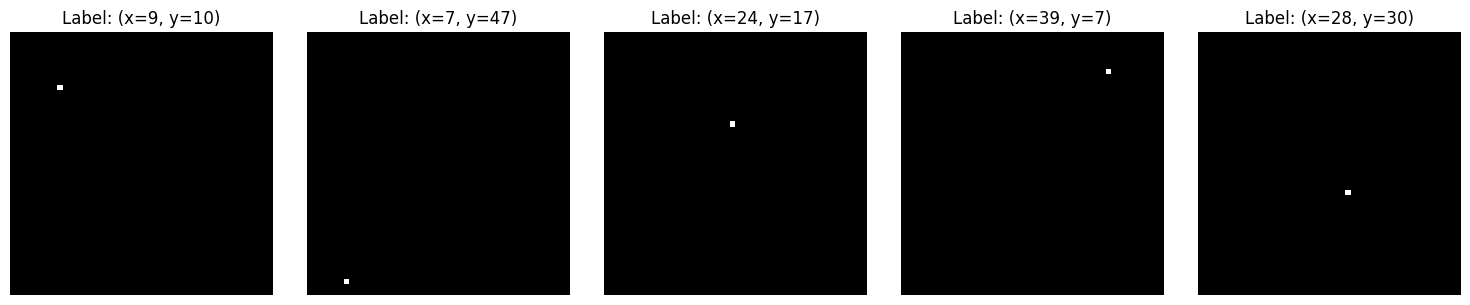

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import os

# Configuration
IMAGE_SIZE = 50
NUM_TRAIN = 10000
NUM_VAL = 2000
NUM_TEST = 1000

def generate_data(num_samples, img_size):
    """Generates images and labels."""
    images = np.zeros((num_samples, img_size, img_size), dtype=np.uint8)
    labels = np.zeros((num_samples, 2), dtype=np.float32)
    
    for i in range(num_samples):
        x = np.random.randint(0, img_size)
        y = np.random.randint(0, img_size)
        images[i, y, x] = 255
        labels[i] = [x, y]
        
    return images, labels

def main():
    print("Generating dataset...")
    
    # Generate splits
    x_train, y_train = generate_data(NUM_TRAIN, IMAGE_SIZE)
    x_val, y_val = generate_data(NUM_VAL, IMAGE_SIZE)
    x_test, y_test = generate_data(NUM_TEST, IMAGE_SIZE)
    
    print(f"Train shape: {x_train.shape}, Labels: {y_train.shape}")
    print(f"Val shape: {x_val.shape}, Labels: {y_val.shape}")
    print(f"Test shape: {x_test.shape}, Labels: {y_test.shape}")
    
    # Save dataset
    output_file = 'dataset.npz'
    np.savez_compressed(output_file, 
                        x_train=x_train, y_train=y_train,
                        x_val=x_val, y_val=y_val,
                        x_test=x_test, y_test=y_test)
    print(f"Dataset saved to {output_file}")
    
    # Visualize samples
    print("Generating sample visualization...")
    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        idx = np.random.randint(0, NUM_TRAIN)
        img = x_train[idx]
        label = y_train[idx]
        
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        plt.title(f"Label: (x={int(label[0])}, y={int(label[1])})")
        plt.axis('off')
        
        # Verify verify that the pixel at label is indeed 255
        assert img[int(label[1]), int(label[0])] == 255, "Label mismatch!"
        
    plt.tight_layout()
    plt.savefig('sample_images.png')
    print("Sample visualization saved to sample_images.png")

if __name__ == "__main__":
    main()


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Load Data
data = np.load('dataset.npz')
IMAGE_SIZE = 50

# Normalize inputs and targets (CRITICAL for improved accuracy)
x_train = np.expand_dims(data['x_train'].astype('float32') / 255.0, axis=-1)
y_train = data['y_train'].astype('float32') / float(IMAGE_SIZE) # Normalize target to 0-1 range

# 2. Define Improved Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 1)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='sigmoid')  # Sigmoid used because targets are normalized to 0-1 range
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 3. Train and Save
print("Training improved model...")
model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
model.save('model_improved.keras')
print("Saved model_improved.keras!")

2026-02-14 17:53:41.124778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771091621.311745      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771091621.373272      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771091621.836283      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771091621.836340      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771091621.836343      24 computation_placer.cc:177] computation placer alr

Training improved model...
Epoch 1/20


I0000 00:00:1771091639.069929      67 service.cc:152] XLA service 0x7d3f70014fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771091639.069965      67 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771091639.700529      67 cuda_dnn.cc:529] Loaded cuDNN version 91002


 25/250 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0487 - mae: 0.1852

I0000 00:00:1771091643.616426      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0142 - mae: 0.0821 - val_loss: 0.2360 - val_mae: 0.4041
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0023 - mae: 0.0373 - val_loss: 0.1111 - val_mae: 0.2850
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0017 - mae: 0.0327 - val_loss: 0.0057 - val_mae: 0.0680
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0015 - mae: 0.0301 - val_loss: 0.0600 - val_mae: 0.1876
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013 - mae: 0.0280 - val_loss: 4.2828e-04 - val_mae: 0.0156
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0012 - mae: 0.0273 - val_loss: 6.4484e-04 - val_mae: 0.0192
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0012 - mae: 0.0268 - val_loss: 7.1816e-04 - val_mae: 0.0207
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011 - mae: 0.0257 - val_loss: 2.0801e-04 - val_mae: 0.0114
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/st

Loading dataset...
Loading model from model_improved.keras...
Running predictions...
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

--- Validation Metrics ---
Mean Euclidean Error: 2.0730 pixels
Median Euclidean Error: 2.0074 pixels
Max Euclidean Error: 4.4318 pixels
MAE X-coord: 1.1116 pixels
MAE Y-coord: 1.5392 pixels
Error distribution plot saved to error_distribution.png
Worst predictions plot saved to worst_predictions.png

Validation complete!


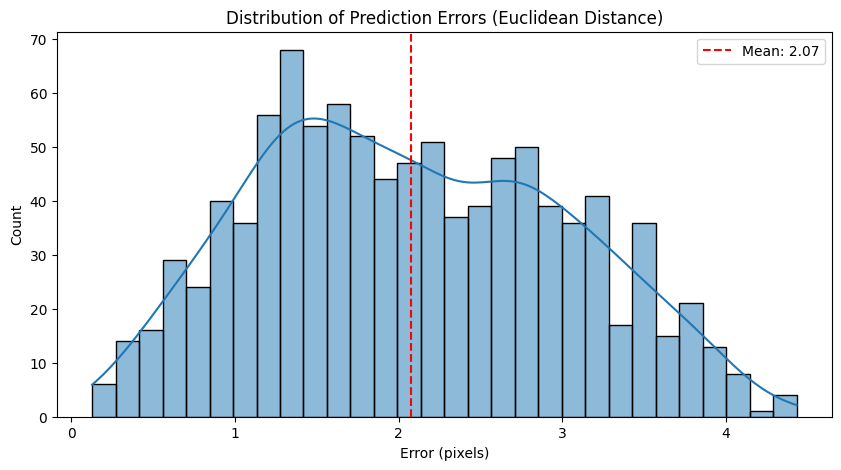

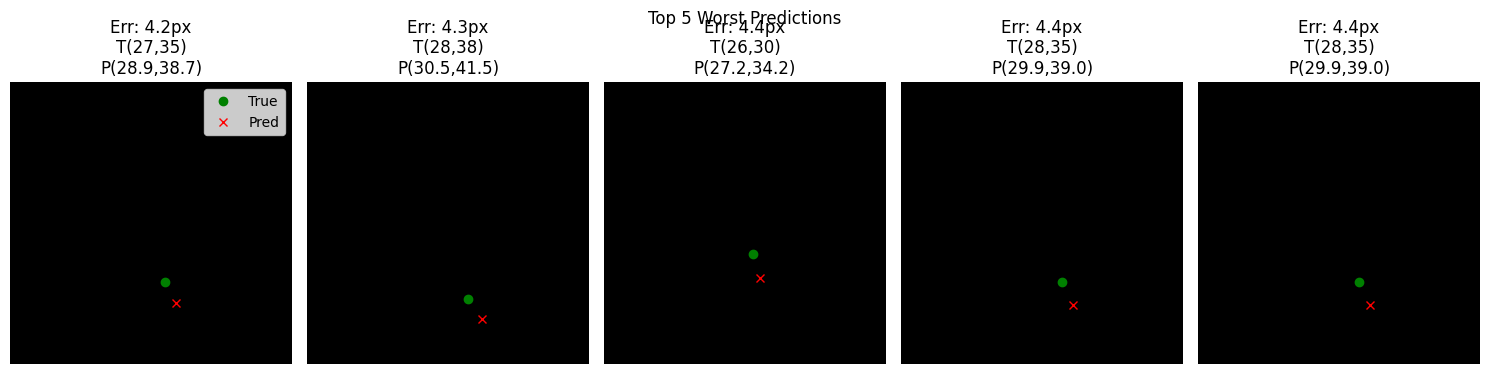

In [4]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

# Configuration
MODEL_PATH = 'model_improved.keras'
DATASET_PATH = 'dataset.npz'
IMAGE_SIZE = 50

def load_data():
    """Loads and preprocesses test data."""
    print("Loading dataset...")
    data = np.load(DATASET_PATH)
    x_test = data['x_test'].astype('float32') / 255.0
    y_test = data['y_test'].astype('float32')
    
    # Expand dims
    x_test = np.expand_dims(x_test, axis=-1)
    
    return x_test, y_test

def calculate_metrics(y_true, y_pred):
    """Calculates detailed metrics."""
    # Euclidean distance error per point
    errors = np.sqrt(np.sum((y_true - y_pred)**2, axis=1))
    
    mae_x = np.mean(np.abs(y_true[:, 0] - y_pred[:, 0]))
    mae_y = np.mean(np.abs(y_true[:, 1] - y_pred[:, 1]))
    
    print(f"\n--- Validation Metrics ---")
    print(f"Mean Euclidean Error: {np.mean(errors):.4f} pixels")
    print(f"Median Euclidean Error: {np.median(errors):.4f} pixels")
    print(f"Max Euclidean Error: {np.max(errors):.4f} pixels")
    print(f"MAE X-coord: {mae_x:.4f} pixels")
    print(f"MAE Y-coord: {mae_y:.4f} pixels")
    
    return errors

def visualize_errors(errors):
    """Plots error distribution."""
    plt.figure(figsize=(10, 5))
    sns.histplot(errors, kde=True, bins=30)
    plt.title('Distribution of Prediction Errors (Euclidean Distance)')
    plt.xlabel('Error (pixels)')
    plt.ylabel('Count')
    plt.axvline(np.mean(errors), color='r', linestyle='--', label=f'Mean: {np.mean(errors):.2f}')
    plt.legend()
    plt.savefig('error_distribution.png')
    print("Error distribution plot saved to error_distribution.png")

def visualize_worst_cases(x_test, y_true, y_pred, errors, n=5):
    """Visualizes samples with the highest errors."""
    worst_indices = np.argsort(errors)[-n:]
    
    plt.figure(figsize=(15, 4))
    plt.suptitle(f"Top {n} Worst Predictions")
    
    for i, idx in enumerate(worst_indices):
        plt.subplot(1, n, i+1)
        plt.imshow(x_test[idx].squeeze(), cmap='gray', vmin=0, vmax=1)
        
        # Plot true (green) and pred (red) points
        # Note: imshow origin is top-left. Labels are (x, y).
        # x is column, y is row.
        true_x, true_y = y_true[idx]
        pred_x, pred_y = y_pred[idx]
        
        plt.plot(true_x, true_y, 'go', label='True')
        plt.plot(pred_x, pred_y, 'rx', label='Pred')
        
        plt.title(f"Err: {errors[idx]:.1f}px\nT({int(true_x)},{int(true_y)})\nP({pred_x:.1f},{pred_y:.1f})")
        if i == 0: plt.legend()
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig('worst_predictions.png')
    print("Worst predictions plot saved to worst_predictions.png")

def main():
    # 1. Load Data
    x_test, y_test = load_data()
    
    # 2. Load Model
    print(f"Loading model from {MODEL_PATH}...")
    model = tf.keras.models.load_model(MODEL_PATH)
    
    # 3. Predict
    print("Running predictions...")
    preds_norm = model.predict(x_test)
    preds_denorm = preds_norm * IMAGE_SIZE
    
    # 4. Metrics
    errors = calculate_metrics(y_test, preds_denorm)
    
    # 5. Visualizations
    visualize_errors(errors)
    visualize_worst_cases(x_test, y_test, preds_denorm, errors)
    
    print("\nValidation complete!")

if __name__ == "__main__":
    main()


Loading model from model_improved.keras...
Generating 5 fresh random images...
Inference results saved to test_inference.png


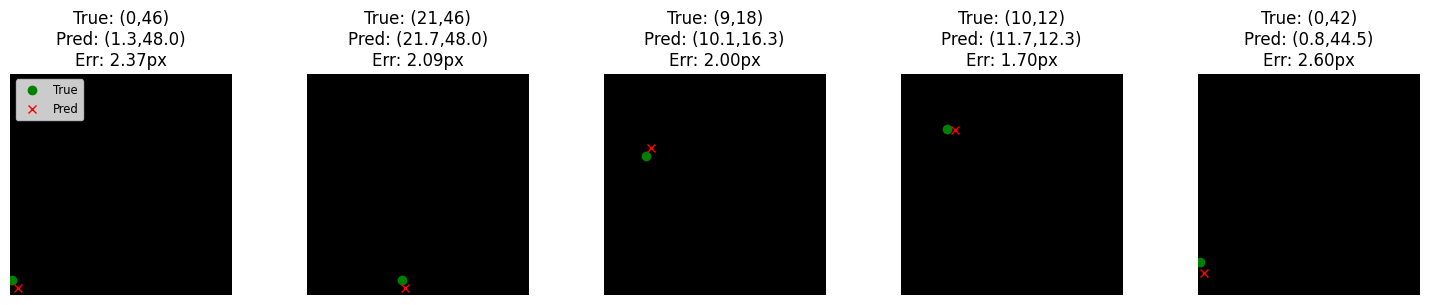

In [5]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Configuration
MODEL_PATH = 'model_improved.keras'
IMAGE_SIZE = 50

def generate_random_inference_image():
    """Generates a single random image for inference."""
    image = np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)
    x = np.random.randint(0, IMAGE_SIZE)
    y = np.random.randint(0, IMAGE_SIZE)
    image[y, x] = 255
    return image, (x, y)

def main():
    # 1. Load Model
    print(f"Loading model from {MODEL_PATH}...")
    try:
        model = tf.keras.models.load_model(MODEL_PATH)
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    print("Generating 5 fresh random images...")
    
    plt.figure(figsize=(15, 3))
    
    for i in range(5):
        # 2. Generate Data
        img, (true_x, true_y) = generate_random_inference_image()
        
        # 3. Preprocess
        # Normalize: [0, 255] -> [0, 1]
        img_input = img.astype('float32') / 255.0
        # Expand dims: (50, 50) -> (1, 50, 50, 1)
        img_input = np.expand_dims(img_input, axis=-1)
        img_input = np.expand_dims(img_input, axis=0)
        
        # 4. Predict
        pred_norm = model.predict(img_input, verbose=0)
        pred_denorm = pred_norm * IMAGE_SIZE
        pred_x, pred_y = pred_denorm[0]
        
        # Calculate Error
        error = np.sqrt((true_x - pred_x)**2 + (true_y - pred_y)**2)
        
        # 5. Visualize
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        
        # Plot markers
        plt.plot(true_x, true_y, 'go', label='True')
        plt.plot(pred_x, pred_y, 'rx', label='Pred')
        
        plt.title(f"True: ({true_x},{true_y})\nPred: ({pred_x:.1f},{pred_y:.1f})\nErr: {error:.2f}px")
        plt.axis('off')
        if i == 0: plt.legend(loc='upper left', fontsize='small')

    plt.tight_layout()
    plt.savefig('test_inference.png')
    print("Inference results saved to test_inference.png")

if __name__ == "__main__":
    main()
